In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

This notebook compares the predictive capabilities of various regression techniques. The models will be trained to predict the power conversion efficiency (PCE), open-circuit voltage ($V_{G}$), short-circuit current density ($J_{SC}$), and fill factor (FF). The predictions will be made based on different combinations of data that describes the device fabrication conditions and active-layer morphology.

The tested regression models are:
- LASSO
- Random Forest
- Support Vector Machine
- Naive Bayes

In other notebooks, the same datasets, as well as image-like data are used to train various neural network models. The results of these models are imported for comparison to the above models.

Below are the two dataframes for the comparison with standard regression models. `device_df` contains photovoltaic performances for Glass/ITO/ZnO/P3HT:PC$_{61}$BM/MoO3/Ag devices. Thermal annealing time and temperature is varied for the samples to optimize their performance.

In [2]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print(len(device_df))
device_df.head()

366


,Unnamed: 0,Unnamed: 0.1,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
0,0,291,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,5,0,0.053196,0.088773,2.319470,25.835041,1
1,1,283,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,5,0,0.323514,0.706579,2.021489,22.649638,7
2,2,284,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,6,0,0.620043,0.665916,1.867738,49.852415,7
3,3,280,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,2,0,0.628255,0.654254,1.915640,50.127434,7
4,4,287,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,1,0,0.637683,0.662407,2.204954,43.659713,1


`total_df` contains morphology information. Atomic force microscopy (AFM) images were segmented and labeled into morphological domains using m2py. Those label maps were used to measure various features of the domains, which each also has an associated phase label (corresponding to P3HT-, PC$_{61}$BM-rich, or mixed regions), as determined by m2py from AFM mechanical property measurements. The average of each morphological feature for phase 1, phase 2, and phase 3 (in the AFM images of the above photovoltaic devices' active layers) are shown with their associated device processing parameters.

Note: Not every device in `device_df` has a corresponding image, so `total_df` is smaller. Further, `total_df` contains images of devices not reported in `device_df`. A subset of devices with associated AFM image are used as validation data across models

In [3]:
total_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_total_df.xlsx', dtype = np.float32)
print(len(total_df))
total_df.head()

108


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0.0,15.0,100.0,4.0,2.0,17.194653,29.172066,8.554722,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003242,352.677582,1.0,2.311387,0.577792,6.963861,57.444839
1,1.0,15.0,100.0,4.0,4.0,13.709727,14.635628,6.938374,7.985216,0.824878,0.138410,-0.205623,1.075388,48.559551,98.492592,1.0,1.763230,0.522596,7.047848,47.872559
2,2.0,15.0,100.0,4.0,7.0,18.211098,21.013542,8.857453,10.356934,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456619,1.0,2.394418,0.575790,6.939877,59.921700
3,3.0,30.0,100.0,7.0,2.0,19.640308,46.935627,9.781374,26.994707,0.857443,0.105577,-0.331902,0.940640,236.482361,1306.085205,1.0,2.628197,0.569525,7.301575,63.201691
4,4.0,30.0,100.0,7.0,4.0,20.647291,35.791550,8.412560,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148926,1.0,2.710602,0.568631,7.328048,65.049927


# NOTE: should calculate and include pixel area and $\frac{%GMM_label}{domian_area}$ (like porosity) for each domain

First, a visualization of `device_df`:

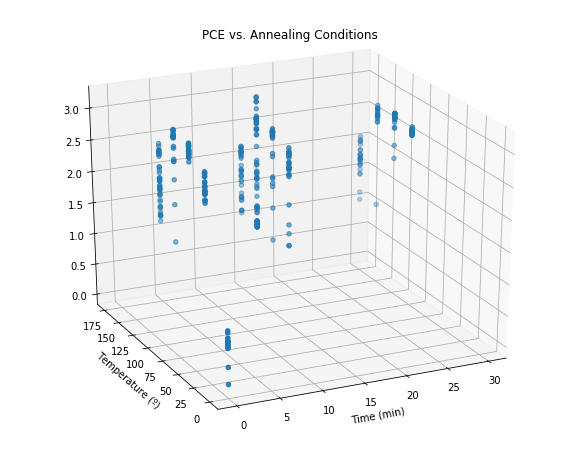

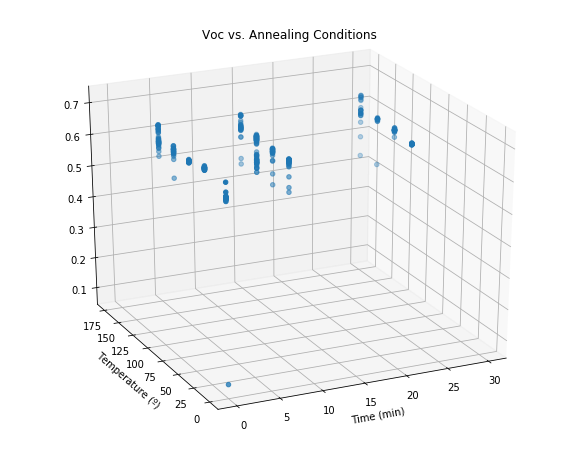

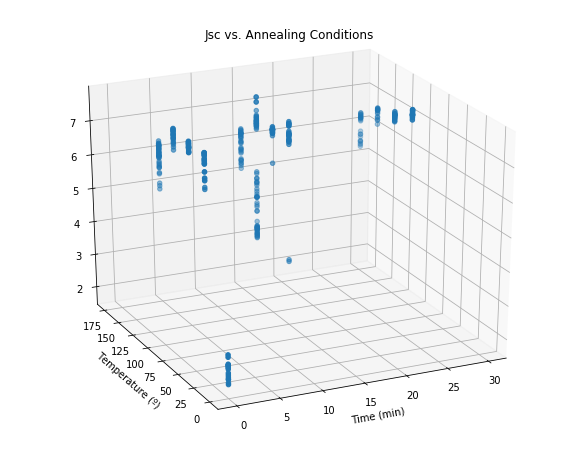

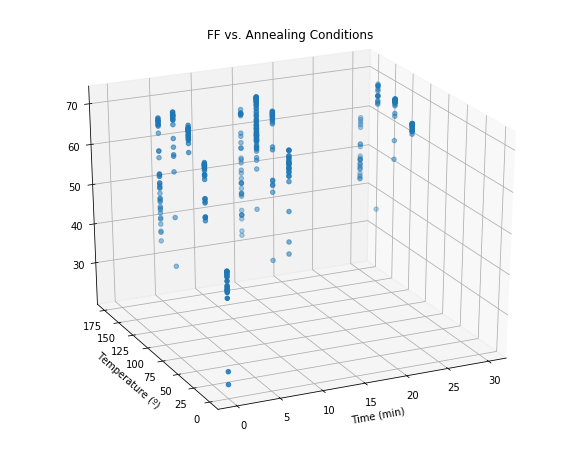

In [4]:
x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['PCE']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('PCE vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['VocL']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Voc vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['Jsc']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Jsc vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time (min)']
y1 = device_df['Temp (C)']
z1 = device_df['FF']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('FF vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

There are 5 different morphological features that m2py tracks: major axis length, minor axis length, eccentricity, perimeter, and orientation. This is implemented from `skimage.measure.region_props_table()`. In the dataframe `total_df`, the average and standard deviation of each morphological feature is tracked and is calculated per phase of each AFM image.

Shown below is the average major axis length for every phase plotted by annealing time and temperature

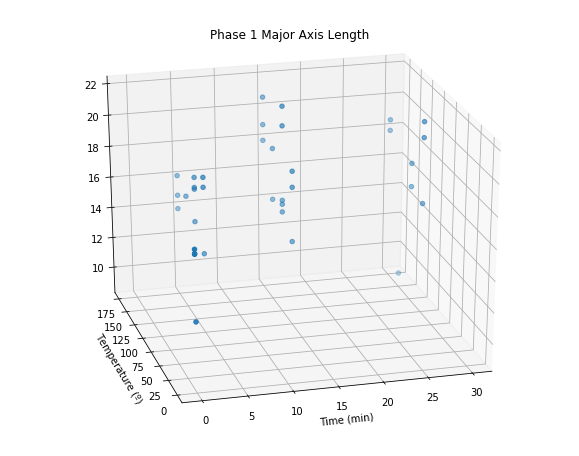

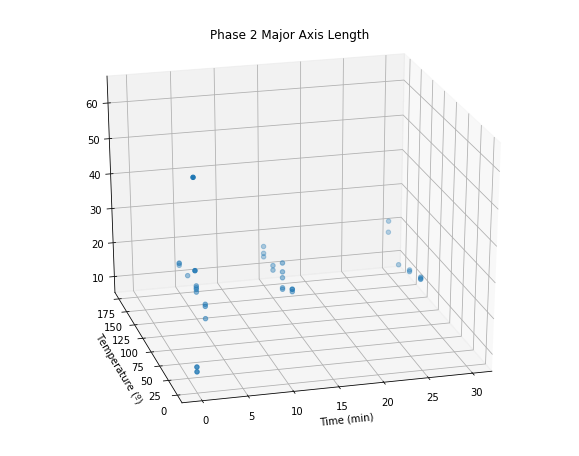

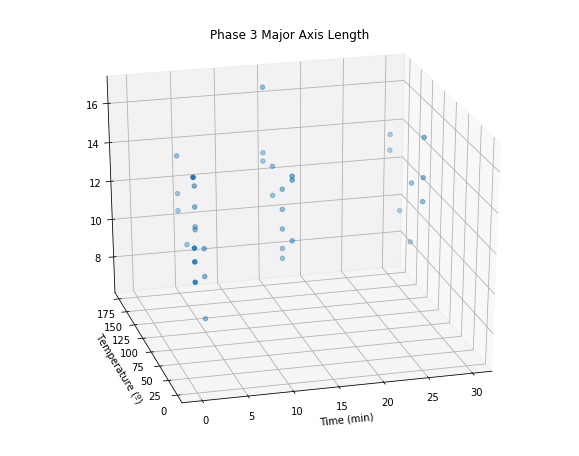

In [5]:
Phase1 = total_df[total_df['GMM_label'] == 1]
Phase2 = total_df[total_df['GMM_label'] == 2]
Phase3 = total_df[total_df['GMM_label'] == 3]

x1 = Phase1['Anneal_time']
y1 = Phase1['Anneal_temp']
z1 = Phase1['MajorAL_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 1 Major Axis Length')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x2 = Phase2['Anneal_time']
y2 = Phase2['Anneal_temp']
z2 = Phase2['MajorAL_avg']
fig2 = plt.figure(figsize = (10,8))
ax2 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 2 Major Axis Length')
ax2.scatter3D(x2,y2,z2)
ax2.view_init(25, 255)
plt.show()

x3 = Phase3['Anneal_time']
y3 = Phase3['Anneal_temp']
z3 = Phase3['MajorAL_avg']
fig3 = plt.figure(figsize = (10,8))
ax3 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 3 Major Axis Length')
ax3.scatter3D(x3,y3,z3)
ax3.view_init(25, 255)
plt.show()

Before any regression is done, the data needs to first be partitioned into training, and testing data. As noted earlier, the testing data will need to be only devices that also have corresponding AFM of their active layers. This is to be able to compare these models with neural network models trained on image data.

In [7]:
# total_df_ids = total_df[['Anneal_time', 'Anneal_temp', 'Substrate', 'Device']]
# device_df_ids = device_df[['Time (min)', 'Temp (C)', 'Substrate', 'Device']]

test_pop = pd.DataFrame()

for i in range(len(total_df['Anneal_time'])):
    time = total_df['Anneal_time'].iloc[i]
    temp = total_df['Anneal_temp'].iloc[i]
    sub = total_df['Substrate'].iloc[i]
    dev = total_df['Device'].iloc[i]

    match = device_df.query('`Time (min)` == @time & `Temp (C)` == @temp & Substrate == @sub & Device == @dev')
    
    if len(match) > 0:
        test_pop = test_pop.append(total_df.iloc[i])
    else:
        pass
    
print(f"There are {len(test_pop)} samples in the possible testing population")
test_pop.head()

There are 93 samples in the possible testing population


,Anneal_temp,Anneal_time,Device,Ecc_avg,Ecc_stdev,FF,GMM_label,Jsc,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Orient_avg,Orient_stdev,PCE,Perim_avg,Perim_stdev,Substrate,Unnamed: 0,VocL
0,100.0,15.0,2.0,0.820518,0.142370,57.444839,1.0,6.963861,17.194653,29.172066,8.554722,14.246681,-0.050137,1.067225,2.311387,97.003242,352.677582,4.0,0.0,0.577792
1,100.0,15.0,4.0,0.824878,0.138410,47.872559,1.0,7.047848,13.709727,14.635628,6.938374,7.985216,-0.205623,1.075388,1.763230,48.559551,98.492592,4.0,1.0,0.522596
2,100.0,15.0,7.0,0.826205,0.148190,59.921700,1.0,6.939877,18.211098,21.013542,8.857453,10.356934,-0.414390,1.047842,2.394418,75.736366,151.456619,4.0,2.0,0.575790
3,100.0,30.0,2.0,0.857443,0.105577,63.201691,1.0,7.301575,19.640308,46.935627,9.781374,26.994707,-0.331902,0.940640,2.628197,236.482361,1306.085205,7.0,3.0,0.569525
4,100.0,30.0,4.0,0.833485,0.136928,65.049927,1.0,7.328048,20.647291,35.791550,8.412560,11.216702,-0.454930,0.862964,2.710602,96.093361,315.148926,7.0,4.0,0.568631


Because we have 93 of 108 possible testing samples in `total_df`, approximately 30 are selected at random for testing

In [12]:
total_test = test_pop.sample(n = 30)
total_test.head()

,Anneal_temp,Anneal_time,Device,Ecc_avg,Ecc_stdev,FF,GMM_label,Jsc,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Orient_avg,Orient_stdev,PCE,Perim_avg,Perim_stdev,Substrate,Unnamed: 0,VocL
43,100.0,5.0,4.0,0.821945,0.139755,59.841412,2.0,6.663984,13.365225,15.706930,6.079744,5.583549,-0.164073,1.045244,2.320462,42.623943,77.355339,1.0,7.0,0.581887
97,175.0,15.0,3.0,0.850319,0.127663,63.554230,3.0,5.384771,16.509291,13.709723,6.630976,4.964053,-0.049541,1.102005,2.102272,42.918377,45.728901,4.0,25.0,0.614295
18,125.0,5.0,6.0,0.841851,0.135324,65.584953,1.0,6.764324,16.789459,21.756308,7.947310,11.246268,0.206292,1.048700,2.528163,76.179199,217.906769,1.0,18.0,0.569871
12,125.0,15.0,7.0,0.841189,0.135878,69.496529,1.0,6.947185,14.836016,17.016523,7.204459,9.205275,0.275916,1.106211,2.738700,58.930725,129.850113,4.0,12.0,0.567247
4,100.0,30.0,4.0,0.833485,0.136928,65.049927,1.0,7.328048,20.647291,35.791550,8.412560,11.216702,-0.454930,0.862964,2.710602,96.093361,315.148926,7.0,4.0,0.568631


So, the training data is now our original dataframes, minus the testing data samples

In [14]:
total_train = total_df.copy()
print(len(total_train))

index = total_test.index
print(index)
    
total_train = total_train.drop(index)
print(len(total_train))

108
Int64Index([ 43,  97,  18,  12,   4, 101,  98,  52,  50,  19,  88,   6,  81,
              5,  92,   3,  83,  33,  49,  42,  95,  84,  60,  31,   7,  82,
             39,  90, 103,  78],
           dtype='int64')
78


We don't have to be so picky about our train-test split for the `device_df`

In [15]:
device_test = device_df.sample(n = 30)
dev_idx = device_test.index
device_train = device_df.copy()
device_train = device_train.drop(dev_idx)

print(len(device_df))
print(len(device_train))
print(len(device_test))

366
336
30
